### DecomposableAttention

In [1]:
import os
import re
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### Seed Setting

```markdown
In here, the code sets the random seed for reproducibility PyTorch operations. This ensures consistent results by fixing the seed for both CPU and GPU computations.
```

In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

#### Data Loading

```markdown
In here, the code defines the read_snli function to load and preprocess the Stanford Natural Language Inference (SNLI) dataset. It reads the dataset files, extracts premises, hypotheses, and labels, and maps the textual labels to numerical indices.
```

In [4]:
def read_snli(data_dir, is_train):
    def extract_text(s):
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

#### Dataset

```markdown
In here, the code defines the SNLIDataset class, which serves as a custom dataset for the SNLI data. It handles tokenization, vocabulary creation, sequence padding, and label encoding to prepare the data for model training and evaluation.
```

In [5]:
class SNLIDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

#### DataLoader

```markdown
In here, the code defines the load_data_snli function, which loads the SNLI dataset, creates training and testing datasets using the SNLIDataset class, and wraps them in PyTorch DataLoader objects for batching and shuffling during training and evaluation.
```

In [8]:
def load_data_snli(batch_size, num_steps=50):
    num_workers = 0
    data_dir = os.path.join('..','..','data','snli_1.0')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

In [9]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


In [10]:
print(len(vocab))

18678


#### Embedding Loading

```markdown
In here, the code loads pre-trained GloVe embeddings using the d2l.TokenEmbedding class. It retrieves the embedding vectors corresponding to the tokens in the vocabulary, which are later used to initialize the embedding layer of the model.
```

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]

#### MLP Definition

```markdown
In here, the code defines the mlp function, which constructs a multilayer perceptron (MLP) with specified input dimensions, hidden layers, activation functions, dropout, and optional flattening. This MLP is used in various components of the decomposable attention model.
```

In [40]:
def mlp(num_inputs, hidden_dim, flatten):
    # Multi-Layer Perceptron (MLP) Construction
    net = []
    # Dropout Layer for Regularization
    net.append(nn.Dropout(0.2))
    # Fully Connected Layer for Transformation
    net.append(nn.Linear(num_inputs, hidden_dim))
    # Activation Layer for Non-Linear Transformation
    net.append(nn.ReLU())
    # Flatten Layer (Optional Based on Parameter)
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    # Dropout Layer for Regularization
    net.append(nn.Dropout(0.2))
    # Fully Connected Layer for Further Transformation
    net.append(nn.Linear(hidden_dim, hidden_dim))
    # Activation Layer for Non-Linear Transformation
    net.append(nn.ReLU())
    # Flatten Layer (Optional Based on Parameter)
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    # Sequential Container for MLP
    return nn.Sequential(*net)

#### Attend, Compare, Aggregate Definition

```markdown
In here, the code defines the Attend class, which performs the attention mechanism between premises and hypotheses. It uses an MLP to transform the inputs and computes attention weights to generate attended representations.
```

In [41]:
class Attend(nn.Module):
    def __init__(self, num_inputs, hidden_dim, **kwargs):
        super(Attend, self).__init__(**kwargs)
        # MLP Layer for Attention Mechanism
        self.f = mlp(num_inputs, hidden_dim, flatten=False)

    def forward(self, A, B):
        # Feature Extraction of Premises (A) w/ MLP
        f_A = self.f(A)
        # Feature Extraction of Hypotheses (B) w/ MLP
        f_B = self.f(B)
        # Similarity Scores Calculation Between Premises and Hypotheses
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Weighted Summation of Hypotheses Using Similarity Scores
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Weighted Summation of Premises Using Transposed Similarity Scores
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

```markdown
In here, the code defines the Compare class, which compares the original and attended representations of premises and hypotheses. It concatenates these representations and passes them through an MLP to generate comparison vectors.
```

In [ ]:
class Compare(nn.Module):
    def __init__(self, num_inputs, hidden_dim, **kwargs):
        super(Compare, self).__init__(**kwargs)
        # MLP Layer for Comparison Mechanism
        self.g = mlp(num_inputs, hidden_dim, flatten=False)

    def forward(self, A, B, beta, alpha):
        # Comparison of Premises (A) and Attended Hypotheses (Beta) w/ MLP
        V_A = self.g(torch.cat([A, beta], dim=2))
        # Comparison of Hypotheses (B) and Attended Premises (Alpha) w/ MLP
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

```markdown
In here, the code defines the Aggregate class, which aggregates the comparison vectors from premises and hypotheses. It sums the vectors across the sequence length and passes them through an MLP and a linear layer to produce the final output logits for classification.
```

In [ ]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, hidden_dim, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        # MLP Layer for Aggregating Comparison Features
        self.h = mlp(num_inputs, hidden_dim, flatten=True)
        # Fully Connected Layer for Mapping Aggregated Features to Output
        self.linear = nn.Linear(hidden_dim, num_outputs)

    def forward(self, V_A, V_B):
        # Summation of Comparison Features for Premises (V_A)
        V_A = V_A.sum(dim=1)
        # Summation of Comparison Features for Hypotheses (V_B)
        V_B = V_B.sum(dim=1)
        # Aggregation and Transformation of Combined Features → Output Predictions
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

#### Model Definition

```markdown
In here, the code defines the DecomposableAttention class, which combines the Attend, Compare, and Aggregate modules to form the complete decomposable attention model for natural language inference. It processes premises and hypotheses to generate logits for entailment, contradiction, or neutral classes.

• Embedding Layer
The model begins by embedding the tokens from the premise and hypothesis using the nn.Embedding layer. This layer transforms discrete tokens into dense vector representations of size embedding_dim, capturing the semantic meaning of each word. These embeddings are shared between the premise and hypothesis, ensuring consistent word representations across both inputs.

• Attend Module
The Attend module computes attention scores between the premise and hypothesis:
- For each token in the premise, attention scores (beta) are calculated with respect to all tokens in the hypothesis, highlighting relevant parts of the hypothesis.
- Similarly, for each token in the hypothesis, attention scores (alpha) are calculated with respect to all tokens in the premise.
- These attended representations enable the model to align tokens from one sequence with the most relevant tokens from the other sequence.

• Compare Module
The Compare module takes the original embeddings of the premise and hypothesis (A and B), along with their attended counterparts (beta and alpha), and computes comparison features:
- V_A is generated by comparing the premise embeddings (A) with the attended hypothesis representations (beta).
- V_B is generated by comparing the hypothesis embeddings (B) with the attended premise representations (alpha).
- These features capture token-level relationships between the premise and hypothesis, such as similarities, differences, or contradictions.

• Aggregate Module
The Aggregate module aggregates the comparison features (V_A and V_B) into a single vector and maps it to the output space. This involves:
- Summarizing the token-level comparison features using techniques such as summation or averaging.
- Passing the aggregated features through fully connected layers to produce the final logits for the classification task (e.g., entailment, contradiction, neutral).
```

In [42]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embedding_dim, hidden_dim, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        # Embedding Layer for Word Representations
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        # Attention Layer for Generating Beta and Alpha
        self.attend = Attend(num_inputs_attend, hidden_dim)
        # Comparison Layer for Generating V_A and V_B
        self.compare = Compare(num_inputs_compare, hidden_dim)
        # Aggregation Layer for Generating Output Predictions
        self.aggregate = Aggregate(num_inputs_agg, hidden_dim, num_outputs=3)

    def forward(self, X):
        # Input Decomposition Into Premises and Hypotheses
        premises, hypotheses = X
        # Embedding of Premises
        A = self.embedding(premises)
        # Embedding of Hypotheses
        B = self.embedding(hypotheses)
        # Attention Mechanism for Premises and Hypotheses
        beta, alpha = self.attend(A, B)
        # Comparison Mechanism for Premises, Hypotheses, and Attended Representations
        V_A, V_B = self.compare(A, B, beta, alpha)
        # Aggregation of Comparison Features → Output Predictions
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [ ]:
embedding_dim, hidden_dim, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embedding_dim, hidden_dim)

In [44]:
net.embedding.weight.data.copy_(embeds)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.2871, -0.5999,  0.4688,  ...,  0.3639, -0.8138, -0.2211],
        [ 0.9682,  0.0718,  0.1710,  ...,  0.1024,  1.3345, -0.4854],
        [ 0.1964,  0.0332,  0.1263,  ...,  0.1077,  0.0260,  0.8928]])

#### Training

```markdown
In here, the code executes the training process by calling the train_ch13 function from the d2l library. This function handles the training loop, including forward passes, loss computation, backpropagation, and parameter updates over the specified number of epochs.
```

loss 0.398, train acc 0.848, test acc 0.840
14414.4 examples/sec on [device(type='cuda', index=0)]


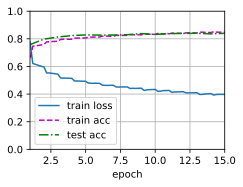

In [46]:
lr, num_epochs = 0.0005, 15
criterion = nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch13(net, train_iter, test_iter, criterion, optimizer, num_epochs, devices)

#### Evaluation Metrics

```markdown
In here, the code defines the cal_metrics function, which evaluates the trained model on the test dataset. It computes evaluation metrics such as accuracy, precision, recall, and F1 score to assess the model's performance.
```

In [49]:
def cal_metrics(model, test_ite):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (premises, hypotheses), labels in test_iter:
            premises = premises.to(device)
            hypotheses = hypotheses.to(device)
            labels = labels.to(device)

            outputs = model([premises, hypotheses])
            predictions = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return None

In [50]:
cal_metrics(net, test_iter)

Accuracy: 0.8398
Precision: 0.8404
Recall: 0.8390
F1 Score: 0.8392


#### Prediction

```markdown
In here, the code defines the predict_nli function, which takes a premise and hypothesis as input, tokenizes and encodes them, passes them through the trained model, and returns the predicted label (entailment, contradiction, or neutral).
```

In [47]:
def predict_nli(net, vocab, premise, hypothesis):
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [48]:
predict_nli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'